In [ ]:
# Import necessary libraries
from pathlib import Path
from typing import NamedTuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [ ]:

# Set up the visual theme for plots
sns.set_theme()


In [ ]:
# Define parameters for the Q-Learning algorithm and environment setup
class Params(NamedTuple):
    total_episodes: int         # Total episodes
    learning_rate: float        # Learning rate
    gamma: float                # Discounting rate
    epsilon: float              # Exploration probability
    map_size: int               # Number of tiles of one side of the squared environment
    seed: int                   # Define a seed so that we get reproducible results
    is_slippery: bool           # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int                 # Number of runs
    action_size: int            # Number of possible actions
    state_size: int             # Number of possible states
    proba_frozen: float         # Probability that a tile is frozen
    savefig_folder: Path        # Root folder where plots are saved

In [ ]:
params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder = Path("./plots"),
)


In [ ]:
rng = np.random.default_rng(params.seed)

# Ensure the folder for saving figures exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)


In [ ]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
#print(f"Action size: {params.action_size}")
#print(f"State size: {params.state_size}")

In [ ]:
class Qlearning:
    # Initialization method
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    # Update method - Implements the core Q-learning update rule
    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    # Method to reset the Q-table to its initial state
    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


In [ ]:
class EpsilonGreedy:
    # Initialization method
    def __init__(self, epsilon):
        self.epsilon = epsilon

    # Method to choose an action based on the current state and Q-table
    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            max_ids = np.where(qtable[state, :] == max(qtable[state, :]))[0]
            action = rng.choice(max_ids)
        return action

In [ ]:
def run_env(params,env):
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):           # Run several times to account for stochasticity



        learner = Qlearning(
            learning_rate=params.learning_rate,
            gamma=params.gamma,
            state_size=params.state_size,
            action_size=params.action_size,
        )

        explorer = EpsilonGreedy(
epsilon=params.epsilon,)


        for episode in tqdm(
            episodes, desc=f"Running Q-Learning {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated
                learner.qtable[state, action] = learner.update(state, action, reward, new_state)
                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [ ]:
def policy_iteration(env_parameters, environment):

    optimal_policy = np.ones(environment.observation_space.n, dtype=int)
    value_function = np.zeros(environment.observation_space.n)

    discount_factor = env_parameters.gamma      # gamma
    theta = 1e-5                # theta

    while True:
        # Update value function based on current policy
        while True:
            delta = 0
            for state in range(environment.observation_space.n):
                prev_value = value_function[state]
                action = optimal_policy[state]

                # Calculate expected return for the current state-action pair
                V = sum(
                    prob * (reward + discount_factor * value_function[next_state])
                    for prob, next_state, reward, _ in environment.unwrapped.P[state][action]
                )

                value_function[state] = V
                delta = max(delta, abs(prev_value - value_function[state]))

            # Check for convergence
            if delta < theta:
                break

        # Update policy by choosing the best action in each state
        policy_stable = True
        for state in range(environment.observation_space.n):
            old_action = optimal_policy[state]

            # Calculate the value for each action and choose the best one
            action_values = [
                sum(
                    prob * (reward + discount_factor * value_function[next_state])
                    for prob, next_state, reward, _ in environment.unwrapped.P[state][action]
                )
                for action in range(environment.action_space.n)
            ]

            best_action = np.argmax(action_values)
            optimal_policy[state] = best_action

            # Check if policy has changed
            if old_action != best_action:
                policy_stable = False

        # Check if policy is stable (no change)
        if policy_stable:
            break

    return optimal_policy, value_function

In [ ]:
def run_policy_iteration(env_parameters, environment):
    rewards_all_runs = np.zeros((env_parameters.total_episodes, env_parameters.n_runs))
    steps_all_runs = np.zeros((env_parameters.total_episodes, env_parameters.n_runs))
    episode_numbers = np.arange(env_parameters.total_episodes)
    all_states_recorded = []
    all_actions_recorded = []

    for run in range(params.n_runs):

        optimal_policy, _ = policy_iteration(env_parameters, environment)

        for episode in tqdm(episode_numbers, desc=f"Policy Iteration Run {run}/{env_parameters.n_runs}", leave=False):
            state = environment.reset(seed=env_parameters.seed)[0]
            step_count = 0
            done = False
            total_episode_reward = 0

            while not done:
                action = optimal_policy[state]
                all_states_recorded.append(state)
                all_actions_recorded.append(action)
                new_state, reward, terminated, truncated, _ = environment.step(action)
                done = terminated or truncated
                total_episode_reward += reward
                step_count += 1
                state = new_state

            rewards_all_runs[episode, run] = total_episode_reward
            steps_all_runs[episode, run] = step_count

    return rewards_all_runs, steps_all_runs, episode_numbers, all_states_recorded, all_actions_recorded


In [ ]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])

    return res, st


In [ ]:
def plot_steps_and_rewards(agg_rewards_df, agg_steps_df, img_name):
    """Plot the steps and rewards for different hyperparameter settings."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Ensure the DataFrame contains the 'hyperparameters' column
    if 'hyperparameters' not in agg_rewards_df.columns:
        raise ValueError("DataFrame must contain a 'hyperparameters' column.")

    # Plotting cumulative rewards
    sns.lineplot(data=agg_rewards_df, x="Episodes", y="cum_rewards", hue="hyperparameters", ax=ax[0])
    ax[0].set_title("Cumulative Rewards")
    ax[0].set_ylabel("Cumulated rewards")

    # Plotting average steps
    sns.lineplot(data=agg_steps_df, x="Episodes", y="Steps", hue="hyperparameters", ax=ax[1])
    ax[1].set_title("Average Steps per Episode")
    ax[1].set_ylabel("Averaged steps number")

    for axi in ax:
        axi.legend(title="Hyperparameters")

    fig.tight_layout()
    img_title = img_name + ".png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")

    plt.show()

In [ ]:
def summarize_results(df):
    grouped = df.groupby('hyperparameters')

    summary_df = pd.DataFrame({
        'Average Rewards': grouped['Rewards'].mean(),
        'Average Cumulated Rewards': grouped['cum_rewards'].mean(),
        'Average Steps': grouped['Steps'].mean()
    }).reset_index()

    return summary_df

In [ ]:
from copy import deepcopy

def sweep_hypermarameters(params, hyperparam_name, hyperparam_values, fixed_params):
    # Aggregated results DataFrames
    results_q_learning = pd.DataFrame()
    results_policy_iter = pd.DataFrame()

    for value in hyperparam_values:
        local_params = deepcopy(params)

        if hyperparam_name == 'learning_rate':
            local_params = local_params._replace(learning_rate=value, gamma=fixed_params['gamma'], epsilon=fixed_params['epsilon'])
            print(f"Ruuning with alpha = {local_params.learning_rate}, gamma = {local_params.gamma}, epsilon = {local_params.epsilon}")

        elif hyperparam_name == 'gamma':
            local_params = local_params._replace(learning_rate=fixed_params['learning_rate'], gamma=value, epsilon=fixed_params['epsilon'])
            print(f"Ruuning with alpha = {local_params.learning_rate}, gamma = {local_params.gamma}, epsilon = {local_params.epsilon}")

        elif hyperparam_name == 'epsilon':
            local_params = local_params._replace(learning_rate=fixed_params['learning_rate'], gamma=fixed_params['gamma'], epsilon=value)
            print(f"Ruuning with alpha = {local_params.learning_rate}, gamma = {local_params.gamma}, epsilon = {local_params.epsilon}")

        # Run Q-Learning and Policy Iteration experiments
        rewards_q, steps_q, episodes_q, _, _, _ = run_env(local_params, env)
        rewards_policy, steps_policy, episodes_policy, _, _ = run_policy_iteration(local_params, env)

        # label param
        label = f"{hyperparam_name}: {value}"

        # Q-Learning
        res_q, st_q = postprocess(episodes_q, local_params, rewards_q, steps_q, local_params.map_size)
        res_q['hyperparameters'] = label
        st_q['hyperparameters'] = label
        results_q_learning = pd.concat([results_q_learning, res_q])

        # Policy iteration
        res_pi, st_pi = postprocess(episodes_policy, local_params, rewards_policy, steps_policy, local_params.map_size)
        res_pi['hyperparameters'] = label
        st_pi['hyperparameters'] = label
        results_policy_iter = pd.concat([results_policy_iter, res_pi])



 # Separate DataFrames for plotting
    plot_steps_and_rewards(
        results_q_learning[['Episodes', 'cum_rewards', 'hyperparameters']],
        results_q_learning[['Episodes', 'Steps', 'hyperparameters']],
        f"sweep_{hyperparam_name}_q_learning"
    )

    plot_steps_and_rewards(
        results_policy_iter[['Episodes', 'cum_rewards', 'hyperparameters']],
        results_policy_iter[['Episodes', 'Steps', 'hyperparameters']],
        f"sweep_{hyperparam_name}_policy_iteration"
    )


    # Print results for analysis
    print(f"\n------ Varying {hyperparam_name}: ------")
    print("\nQ-Learning:")
    print(summarize_results(results_q_learning))

    print("\nPolicy Iteration:")
    print(summarize_results(results_policy_iter))




In [ ]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

Ruuning with alpha = 0.1, gamma = 0.8, epsilon = 0.01


Ruuning with alpha = 0.01, gamma = 0.8, epsilon = 0.01


Ruuning with alpha = 0.001, gamma = 0.8, epsilon = 0.01


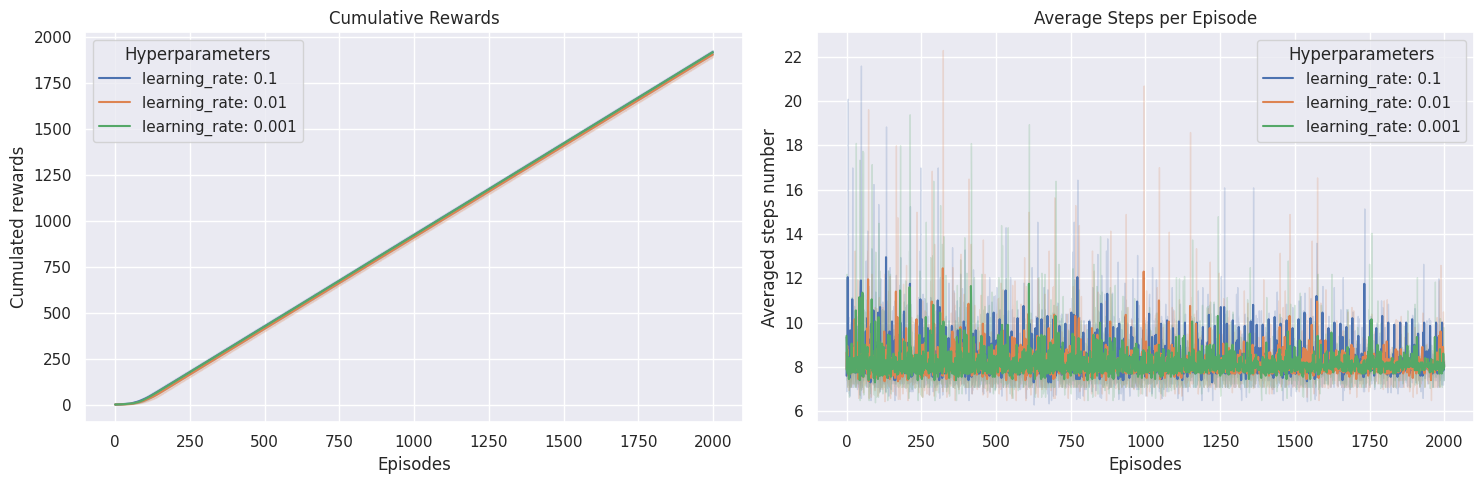

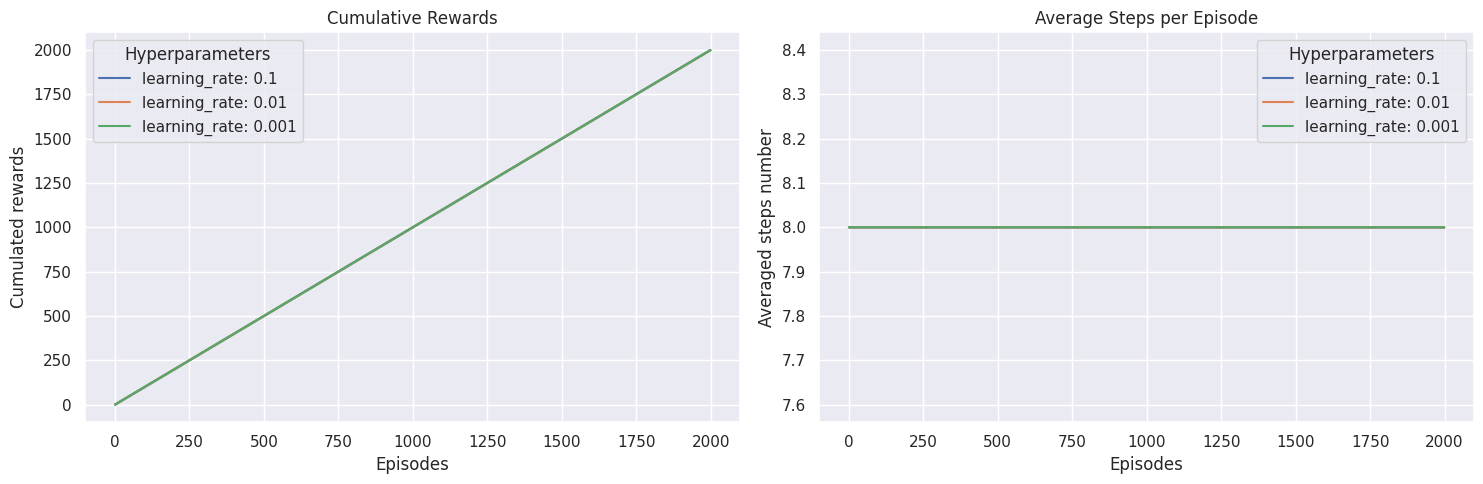


------ Varying learning_rate: ------

Q-Learning:
        hyperparameters  Average Rewards  Average Cumulated Rewards  Average Steps
0  learning_rate: 0.001         0.957425                 922.293275       8.146750
1   learning_rate: 0.01         0.951200                 910.534425       8.142475
2    learning_rate: 0.1         0.957375                 922.572575       8.232625

Policy Iteration:
        hyperparameters  Average Rewards  Average Cumulated Rewards  Average Steps
0  learning_rate: 0.001              1.0                     1000.5            8.0
1   learning_rate: 0.01              1.0                     1000.5            8.0
2    learning_rate: 0.1              1.0                     1000.5            8.0
Ruuning with alpha = 0.1, gamma = 0.8, epsilon = 0.01


Ruuning with alpha = 0.1, gamma = 0.9, epsilon = 0.01


Ruuning with alpha = 0.1, gamma = 0.99, epsilon = 0.01


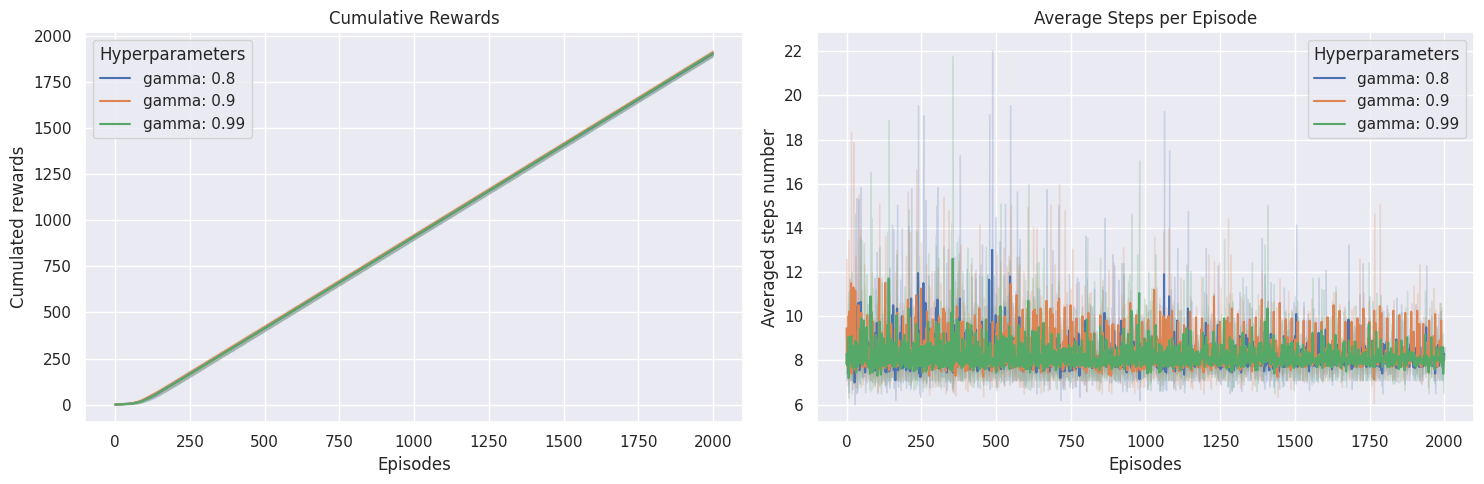

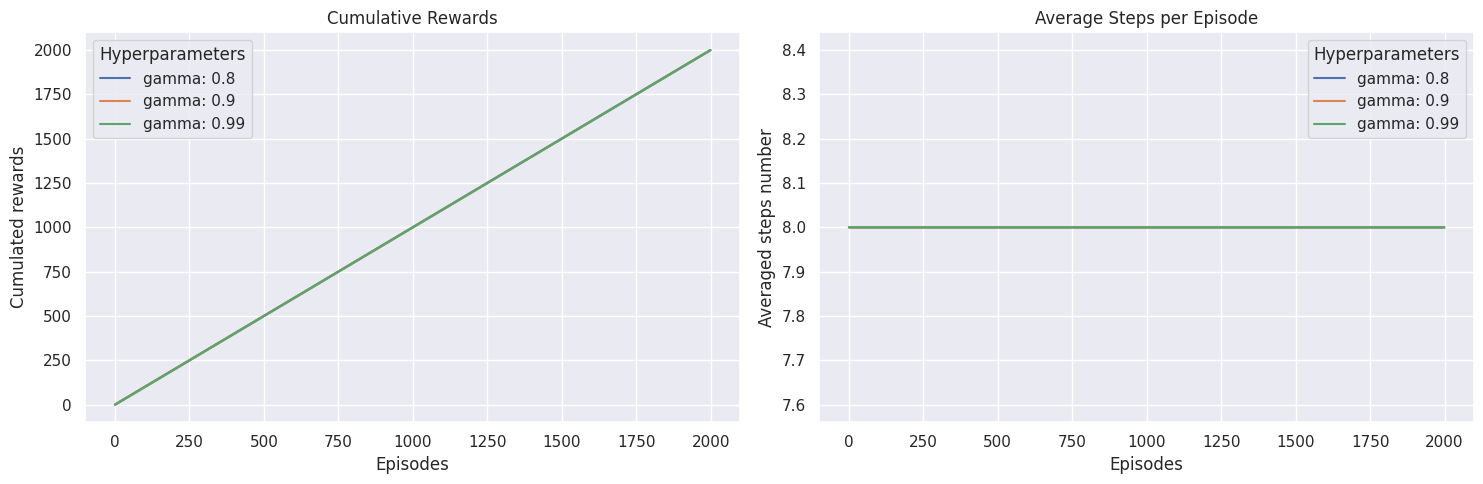


------ Varying gamma: ------

Q-Learning:
  hyperparameters  Average Rewards  Average Cumulated Rewards  Average Steps
0      gamma: 0.8         0.952075                 912.726600       8.161950
1      gamma: 0.9         0.955825                 918.904100       8.249675
2     gamma: 0.99         0.953850                 914.352825       8.150125

Policy Iteration:
  hyperparameters  Average Rewards  Average Cumulated Rewards  Average Steps
0      gamma: 0.8              1.0                     1000.5            8.0
1      gamma: 0.9              1.0                     1000.5            8.0
2     gamma: 0.99              1.0                     1000.5            8.0
Ruuning with alpha = 0.1, gamma = 0.8, epsilon = 0.01


Ruuning with alpha = 0.1, gamma = 0.8, epsilon = 0.1


Ruuning with alpha = 0.1, gamma = 0.8, epsilon = 0.5


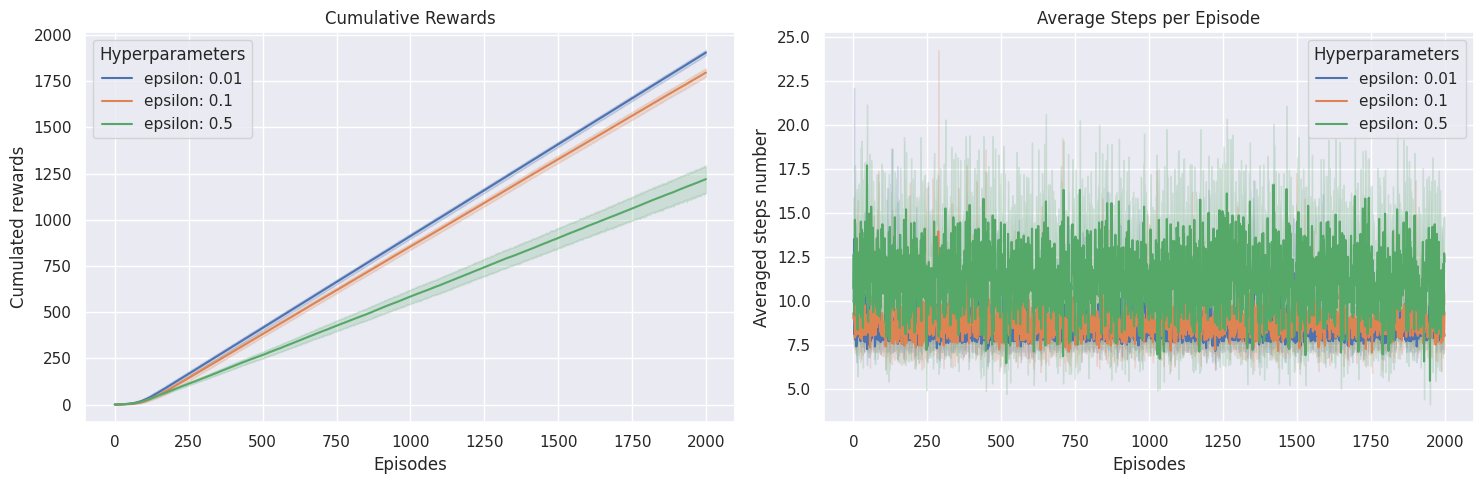

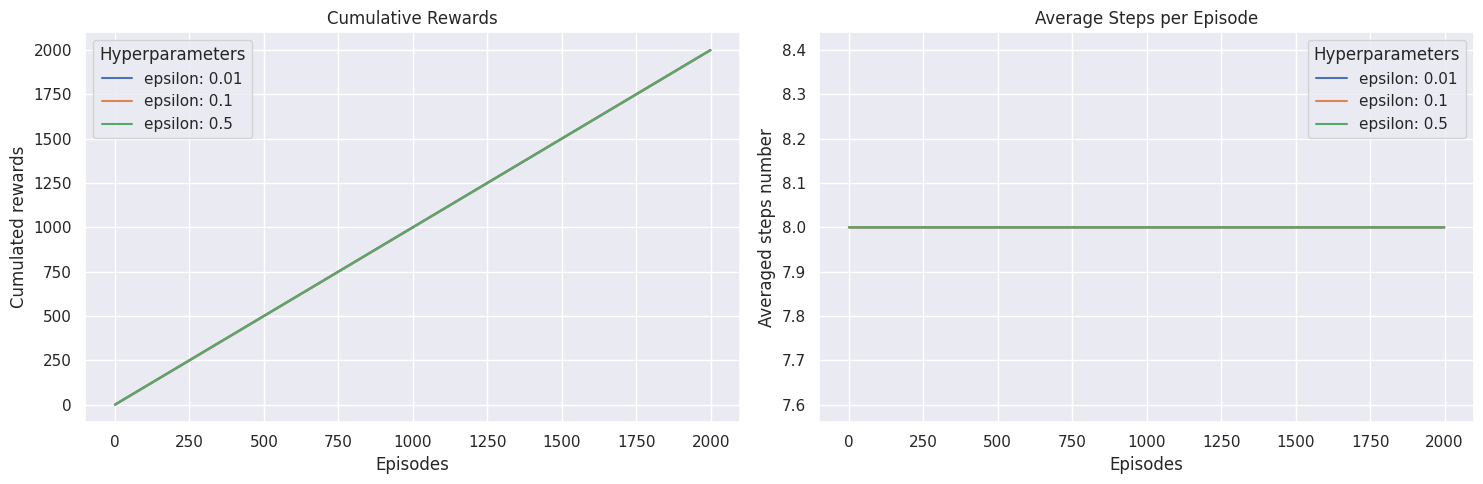


------ Varying epsilon: ------

Q-Learning:
  hyperparameters  Average Rewards  Average Cumulated Rewards  Average Steps
0   epsilon: 0.01         0.952650                 913.561225       8.245875
1    epsilon: 0.1         0.898575                 856.756725       8.687300
2    epsilon: 0.5         0.610050                 586.507450      11.182175

Policy Iteration:
  hyperparameters  Average Rewards  Average Cumulated Rewards  Average Steps
0   epsilon: 0.01              1.0                     1000.5            8.0
1    epsilon: 0.1              1.0                     1000.5            8.0
2    epsilon: 0.5              1.0                     1000.5            8.0


In [ ]:
fixed_params = {'learning_rate': 0.1, 'gamma': 0.8, 'epsilon': 0.01}

lr_range = [0.1, 0.01, 0.001]
gamma_range = [0.8, 0.9, 0.99]
epsilon_range = [0.01, 0.1, 0.5]

#sweep alpha
sweep_hypermarameters(params, 'learning_rate', lr_range, fixed_params)


# Sweep gamma
sweep_hypermarameters(params, 'gamma', gamma_range, fixed_params)


# Sweep epsilon
sweep_hypermarameters(params, 'epsilon', epsilon_range, fixed_params)




In [ ]:


from google.colab import files
import zipfile

!zip -r /content/plots.zip /content/plots
files.download("/content/plots.zip")


  adding: content/plots/ (stored 0%)
  adding: content/plots/sweep_learning_rate_policy_iteration.png (deflated 13%)
  adding: content/plots/sweep_learning_rate_q_learning.png (deflated 3%)
  adding: content/plots/sweep_epsilon_q_learning.png (deflated 2%)
  adding: content/plots/sweep_gamma_q_learning.png (deflated 3%)
  adding: content/plots/sweep_epsilon_policy_iteration.png (deflated 13%)
  adding: content/plots/sweep_gamma_policy_iteration.png (deflated 13%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>